In [17]:
## handling csv file and data
import numpy as np
import pandas as pd

## Plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Labelencoding function
from sklearn.preprocessing import LabelEncoder

## Scaling function
from sklearn.preprocessing import MinMaxScaler

## SMOTE function(for oversampling of minor classes)
from imblearn.over_sampling import SMOTE

## Train-test split function and hyper parameter tuning function
from sklearn.model_selection import train_test_split,GridSearchCV

## Evaluation metrics functions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,ConfusionMatrixDisplay

## For ignoring warnings(may not be necessary)
import warnings
warnings.filterwarnings('ignore')

In [18]:
## Required models from their respective libraries
import xgboost as xgb

In [19]:
## importing dataset
pred_or_sev = "pred"
dataset = pd.read_csv("heart-95.csv")
dataset.shape

(918, 12)

In [20]:
if pred_or_sev == "pred":
  l=['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
  for i in l:
    lbl=LabelEncoder()
    dataset[i] = lbl.fit_transform(dataset[i])
elif pred_or_sev == "sev":
  pass

In [21]:
predictors = dataset.drop("target",axis=1)
target = dataset["target"]
scaler = MinMaxScaler()
predictors = scaler.fit_transform(predictors)

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(predictors,target,test_size=0.20,random_state=0)

oversample = SMOTE()
predictors_SMOTE,target_SMOTE = oversample.fit_resample(predictors, target)
X_train_SMOTE, X_test_SMOTE, Y_train_SMOTE, Y_test_SMOTE = train_test_split(predictors_SMOTE,target_SMOTE,test_size=0.20,random_state=0)


In [23]:
def best_model(model, parameters, X_train, Y_train,search = True):
  if search == False:
    model.fit(X_train, Y_train)
    return model
  else:
    search_model = GridSearchCV(model, parameters, scoring='accuracy')
    result = search_model.fit(X_train, Y_train)
    return result

In [24]:
model = xgb.XGBClassifier()

parameters = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300]
}

In [25]:
def ac(Y_test, Y_pred):
  return round(accuracy_score(Y_test,Y_pred)*100,2)

def ps(Y_test, Y_pred):
  if pred_or_sev == "pred":
    return round(precision_score(Y_test,Y_pred)*100,2)
  else:
    return round(precision_score(Y_test,Y_pred, average='micro')*100,2)

def rs(Y_test, Y_pred):
  if pred_or_sev == "pred":
    return round(recall_score(Y_test,Y_pred)*100,2)
  else:
    return round(recall_score(Y_test,Y_pred, average='micro')*100,2)

def f1(Y_test, Y_pred):
  if pred_or_sev == "pred":
    return round(f1_score(Y_test,Y_pred)*100,2)
  else:
    return round(f1_score(Y_test,Y_pred, average='micro')*100,2)

In [26]:
Y_pred = best_model(model, parameters, X_train, Y_train, False).predict(X_test)

acc1 = ac(Y_test, Y_pred)

prec1 = ps(Y_test, Y_pred)

rec1 = rs(Y_test, Y_pred)

f1_1 = f1(Y_test, Y_pred)

In [27]:
Y_pred = best_model(model, parameters, X_train_SMOTE, Y_train_SMOTE, False).predict(X_test_SMOTE)

acc2 = ac(Y_test_SMOTE, Y_pred)

prec2 = ps(Y_test_SMOTE, Y_pred)

rec2 = rs(Y_test_SMOTE, Y_pred)

f1_2 = f1(Y_test_SMOTE, Y_pred)

In [28]:
result = best_model(model, parameters, X_train, Y_train, True)

print("Best parameters without SMOTE are:", result.best_params_)
Y_pred = result.best_estimator_.predict(X_test)

acc3 = ac(Y_test, Y_pred)

prec3 = ps(Y_test, Y_pred)

rec3 = rs(Y_test, Y_pred)

f1_3 = f1(Y_test, Y_pred)

Best parameters without SMOTE are: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}


In [29]:
result = best_model(model, parameters, X_train_SMOTE, Y_train_SMOTE, True)

print("Best parameters with SMOTE are:", result.best_params_)
Y_pred = result.best_estimator_.predict(X_test_SMOTE)

acc4 = ac(Y_test_SMOTE, Y_pred)

prec4 = ps(Y_test_SMOTE, Y_pred)

rec4 = rs(Y_test_SMOTE, Y_pred)

f1_4 = f1(Y_test_SMOTE, Y_pred)

Best parameters with SMOTE are: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.7}


In [30]:
import pandas as pd
from pandas.io.formats.style import Styler

column_names = pd.DataFrame([["Without gridsearch", "Without SMOTE"],
                             ["Without gridsearch", "With SMOTE"],
                             ["With gridsearch", "Without SMOTE"],
                             ["With gridsearch", "With SMOTE"]],
                             columns=["Metric", ""])

rows = [[acc1, acc2,acc3,acc4],
        [prec1, prec2,prec3,prec4],
        [rec1,rec2,rec3,rec4],
        [f1_1,f1_2,f1_3,f1_4]]

columns = pd.MultiIndex.from_frame(column_names)
index = ["accuracy", "precision", "recall", "f1"]

df = pd.DataFrame(rows, columns=columns, index=index)

styler = Styler(df,precision = 2)
styler.set_properties(**{'text-align': 'center'})

display(styler)

In [31]:
labels = [0,1]
if pred_or_sev == "sev":
    labels = [0,1,2,3,4]

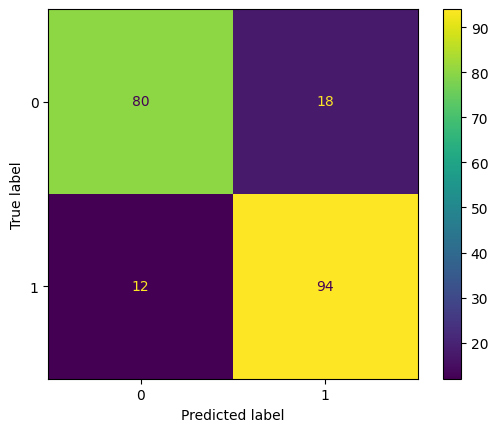

<Figure size 640x480 with 0 Axes>

In [34]:
c = confusion_matrix(Y_test_SMOTE, Y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = c, display_labels = labels)

cm_display.plot()
plt.show()
plt.savefig("Confusion_matrix_XGBoost.png")